# STEP 3 – DBSCAN and co-registration with 3D Forest segmented regions

The goal of step 3 is to separate trees so that in output we have one .las file for each tree. Part of the step 3 is to be done in 3D Forest.

In [2]:
import laspy
from sklearn.cluster import DBSCAN , HDBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os , os.path, shutil
#import hdbscan    ##for scikit-learn <1.3.0

## DBSCAN clustering

Now, let's focus on the lower part of the dataset, that is to say at trunk level (arbitrarily 0.7m to 1.0m). We will first cut off the lower part of the trunk to avoid the integration of terrain in our trunk clusters. We may recover the lower remaining part of the trunk later.

In [3]:
file = 'class2.las' #to modify for each use

In [4]:
path = '3-trees_point_cloud/trees/'
path1 = path + file

print('please insure that the file is located in the following folder:', path)

please insure that the file is located in the following folder: 3-trees_point_cloud/trees/


In [5]:
cloud = laspy.read(path1)

print('parameters available from this las file :', list(cloud.point_format.dimension_names))

scale = cloud.header.scales

x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)

intensity = cloud.intensity.reshape(len(x),1)

CLOUD = np.hstack([x,y,z,intensity])

n , n_param = CLOUD.shape


print('')
print(file,'contains',n,'points and',n_param,'active parameters') 

parameters available from this las file : ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'red', 'green', 'blue', 'Original__cloud__index']

class2.las contains 283072 points and 4 active parameters


In [6]:
ROIzmin = 0.7 #to modify according to the dataset attributes
ROIzmax = 1.3

In [7]:
ROI = CLOUD

#slice we will focus on
CLOUD = CLOUD[CLOUD[:,2]<=ROIzmax]
CLOUD = CLOUD[CLOUD[:,2]>=ROIzmin]

#ROI parts under and above the slice
UP_CLOUD = ROI[ROI[:,2]>ROIzmax]
DOWN_CLOUD = ROI[ROI[:,2]<ROIzmin]

By plotting the resized cloud, we can see that we closely reached our cloud's resolution.

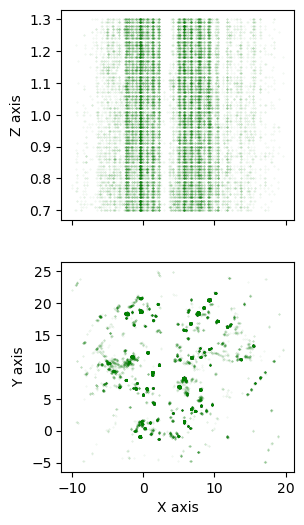

In [8]:
plt.subplots(2,1,sharex=True,figsize=(3,6))
plt.subplot(2,1,1)
plt.scatter(CLOUD[:,0],CLOUD[:,2],s=0.1,alpha=0.1,c='g')
plt.ylabel('Z axis')
plt.subplot(2,1,2)
plt.scatter(CLOUD[:,0],CLOUD[:,1],s=0.1,alpha=0.1,c='g')
plt.ylabel('Y axis')
plt.xlabel('X axis')

plt.show()

Now we can tune our DBScan model, and look for the most efficient parameters.

In [9]:
eps = 0.1
min_samples = 10

In [10]:
db = DBSCAN(eps=eps,min_samples=min_samples).fit(CLOUD)

#db = HDBSCAN(min_cluster_size=min_samples).fit(CLOUD)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(n_clusters_,'clusters,' , n_noise_,f'points of noise ({np.round(100*n_noise_/len(CLOUD))} %)')

#saving trunks clusters in a matrix with a fifth column to identify each one
clusters = np.hstack([CLOUD[labels!=-1],labels[labels!=-1].reshape(len(labels[labels!=-1]),1)])

201 clusters, 22783 points of noise (77.0 %)


We compute the centroid of each cluster simply as the means of the 3 coordinates.

In [11]:
centroids = np.zeros((0,3))

for cluster in set(clusters[:,4]):
    cl = clusters[clusters[:,4]==cluster][:,:3]
    centroid = cl.mean(axis=0)
    centroids = np.vstack([centroids,centroid])

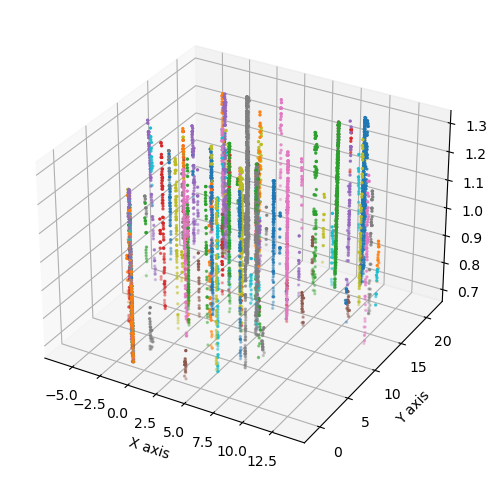

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(6,6))

for cluster in set(clusters[:,4]):
    to_prompt = clusters[clusters[:,4]==cluster]
    ax.scatter(to_prompt[:,0],to_prompt[:,1],to_prompt[:,2],s=2)

plt.xlabel('X axis')
plt.ylabel('Y axis')

plt.show()

We can export our clusters to verify that they are all single trunks. 

In [13]:
path_trunk = '4-separated_trees/DBSCAN_trunks/'

for root, dirs, files in os.walk(path_trunk):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        shutil.rmtree(os.path.join(root, d))

i=0
for cluster in set(clusters[:,4]):
    i = i+1
    cluster_points = clusters[clusters[:,4]==cluster]
    output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
    output_file.x = cluster_points[:,0]
    output_file.y = cluster_points[:,1]
    output_file.z = cluster_points[:,2]
    output_file.intensity = cluster_points[:,3]
    if i<10:
        output_file.write(f"{path_trunk}trunk0{i}.las")
    else:
        output_file.write(f"{path_trunk}trunk{i}.las")

We now create a dictionnary of regions that we sort according to the x,y axis widths of each cluster, from the widest to the thinnest.

In [14]:
regions = {}

for cluster in set(clusters[:,4].astype(int)):
    clust = clusters[clusters[:,4]==cluster][:,:4]
    key = clust[:,0].max()-clust[:,0].min()
    regions[f'{key}_{cluster}'] = [clust , centroids[cluster]]


regions = dict(sorted(regions.items(),reverse=True))

keys = []
for key in regions.keys():
    keys.append(key)

We can observe each trunk's position, and eventually compare it to real coordinates of the trees. We also plot the x-axis wide to visualize if there is any evident outlier on our data.

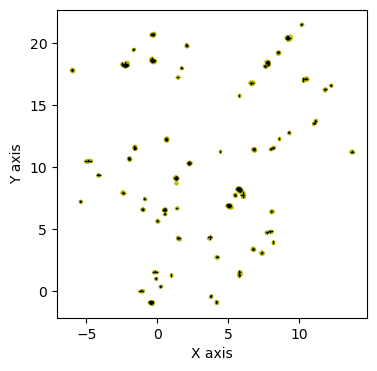

In [15]:
plt.figure(figsize=(4,4))

for region in regions.keys() :
    points = regions[f'{region}'][0]
    xmin = points[:,0].max()
    xmax = points[:,0].min()
    ymin = points[:,1].max()
    ymax = points[:,1].min()
    centroid = regions[f'{region}'][1]
    plt.scatter(points[:,0],points[:,1],s=2,alpha=0.5,c='y')
    plt.plot(np.linspace(xmin,xmax,2),np.array([centroid[1],centroid[1]]),c='k',lw=1)
    plt.plot(np.array([centroid[0],centroid[0]]),np.linspace(ymin,ymax,2),c='k',lw=1)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')

plt.show()

## Co-registration

Let's first reimport the DBSCAN-clustered trunks to save any manual change that can have been done.

In [16]:
print(len(os.listdir(path_trunk)),'files detected in',path_trunk)
files = os.listdir(path_trunk)

files_names = []
for file in files:
    files_names.append(file[:-4])

201 files detected in 4-separated_trees/DBSCAN_trunks/


In [17]:
regions = {}

i = 0

for file_name in files_names:
    
    i += 1
    
    file = files[i-1]
    
    cloud = laspy.read(path_trunk+file)
    scale = cloud.header.scales
    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
    intensity = cloud.intensity.reshape(len(x),1)
    regions[f'{file_name}'] = np.hstack([x,y,z,intensity])

In [18]:
for region in regions:
    centroid = regions[f'{region}'][:,:3].mean(axis=0)
    regions[f'{region}'] = regions[f'{region}'] , centroid

First insure to have correctly done the segmentation of trees in 3D Forest, and re-exported the regions in the planned folder as .txt files.

In [19]:
path_3df_regions = '4-separated_trees/3DForest_segmented_regions/'
print(len(os.listdir(path_3df_regions))-1,'files detected in',path_3df_regions)
files = os.listdir(path_3df_regions)[1:]

files_names = []
for file in files:
    files_names.append(file[:-4])

35 files detected in 4-separated_trees/3DForest_segmented_regions/


Now we create regions similarly to the regions created for DBSCAN clusters.

In [20]:
regions_3df = {}

i = 0

for file_name in files_names:
    
    i += 1
    
    file = files[i-1]
    
    regions_3df[f'{file_name}'] = pd.read_csv(path_3df_regions+file,
                                             delimiter=' ',
                                             header=None,
                                             names=['x','y','z','intensity'])
    
    regions_3df[f'{file_name}'] = np.array(regions_3df[f'{file_name}'])

We look for centroids at the same level than the DBSCAN clusters.

In [21]:
for file_name in files_names:
    
    Slice = regions_3df[f'{file_name}'][regions_3df[f'{file_name}'][:,2]<=ROIzmax]
    Slice = Slice[Slice[:,2]>=ROIzmin]
    centroid = Slice[:,:3].mean(axis=0)
    regions_3df[f'{file_name}'] = regions_3df[f'{file_name}'] , centroid

Let's look at centroids of both kinds of regions, some seem to be highly corresponding, while others haven't been achieved. To reinforce the confidence of our model, we should only select and merge regions obtained with the two methods which can be correlated thanks to the distance between the centroids.

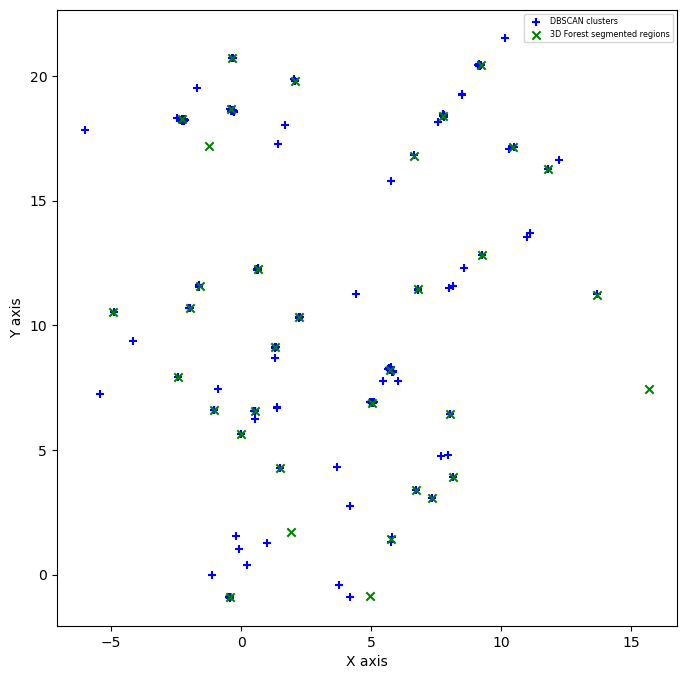

In [22]:
plt.figure(figsize=(8,8))

i=0

for region in regions.keys() :
    i += 1
    points = regions[f'{region}'][0]
    xmin = points[:,0].max()
    xmax = points[:,0].min()
    centroid = regions[f'{region}'][1]
    if i==1:
        plt.scatter(centroid[0],centroid[1],c='b',marker='+',label='DBSCAN clusters')
    else:
        plt.scatter(centroid[0],centroid[1],c='b',marker='+')

i=0

for region in regions_3df.keys():
    i += 1
    points = regions_3df[f'{region}'][0]
    xmin = points[:,0].max()
    xmax = points[:,0].min()
    centroid = regions_3df[f'{region}'][1]
    if i==1:
        plt.scatter(centroid[0],centroid[1],c='g',marker='x',label='3D Forest segmented regions') 
    else:
        plt.scatter(centroid[0],centroid[1],c='g',marker='x')

plt.xlabel('X axis')
plt.ylabel('Y axis')   
plt.legend(fontsize='xx-small')
plt.show()

We now merge the regions having centroids close to each other by less than 0.3 meters in the (x,y) plane.

In [23]:
dist_to_merge = 0.2

In [24]:
centroids = []
reg = []
j=0
for i in range (len(regions_3df)):
    key = list(regions_3df.keys())[j]
    centroid = regions_3df[f'{key}'][1]
    if np.isnan(centroid).any():
        del (regions_3df[f'{key}'])
    else:
        centroids.append(centroid)
        reg.append(regions_3df[f'{key}'][0])
        j+=1
centroids = np.array(centroids)
centroids = centroids[~np.isnan(centroids).any(axis=1)]

new_regions = []
control = 'not_ok'
for region in regions.keys():
    centroid = regions[f'{region}'][1]
    dist =  np.linalg.norm(centroids[:,:2]-centroid[:2],axis=1).min()
    while dist<=dist_to_merge:
        control = 'ok'
        idx_min = np.linalg.norm(centroids[:,:2]-centroid[:2],axis=1).argmin()
        new_region = regions[f'{region}'][0]
        new_region = np.vstack([new_region,np.array(reg[idx_min])])
        centroids = np.delete(centroids,idx_min,axis=0)
        del(reg[idx_min])
        dist =  np.linalg.norm(centroids[:,:2]-centroid[:2],axis=1).min()
    if control=='ok':
        if not any(np.array_equal(new_region, reg) for reg in new_regions):
            new_regions.append(new_region)
        
print(f'{len(new_regions)} regions after merging')

31 regions after merging


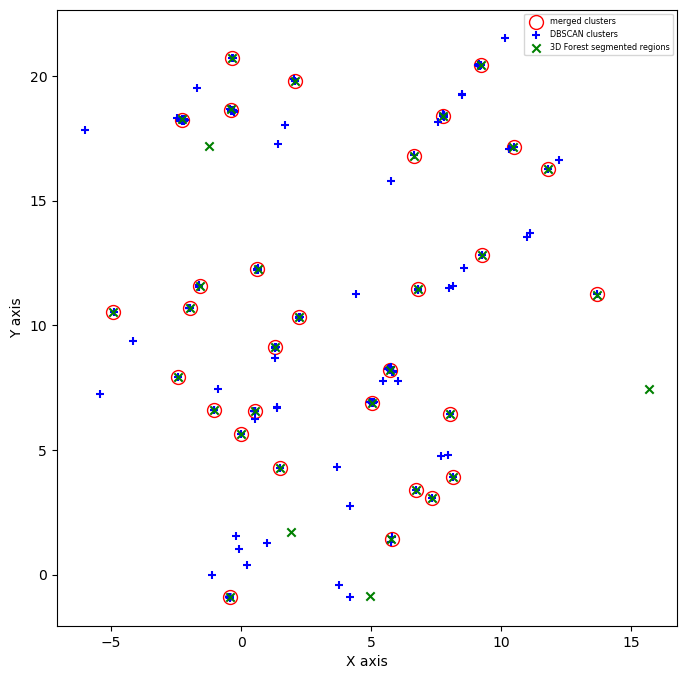

In [25]:
plt.figure(figsize=(8,8))

i=0

new_centroids = []
for region in new_regions:
    i += 1
    Slice = region[region[:,2]>=ROIzmin]
    Slice = Slice[Slice[:,2]<=ROIzmax]
    centroid = Slice[:,:3].mean(axis=0)
    if i==1:
        plt.scatter(centroid[0],centroid[1],marker='o',
                    s=100,c='w',edgecolors='r',
                    label='merged clusters')
    else:
        plt.scatter(centroid[0],centroid[1],marker='o',
                    s=100,c='w',edgecolors='r')
        
i=0

for region in regions.keys() :
    i += 1
    points = regions[f'{region}'][0]
    xmin = points[:,0].max()
    xmax = points[:,0].min()
    centroid = regions[f'{region}'][1]
    if i==1:
        plt.scatter(centroid[0],centroid[1],c='b',marker='+',label='DBSCAN clusters')
    else:
        plt.scatter(centroid[0],centroid[1],c='b',marker='+')

i=0

for region in regions_3df.keys():
    i += 1
    points = regions_3df[f'{region}'][0]
    xmin = points[:,0].max()
    xmax = points[:,0].min()
    centroid = regions_3df[f'{region}'][1]
    if i==1:
        plt.scatter(centroid[0],centroid[1],c='g',marker='x',label='3D Forest segmented regions') 
    else:
        plt.scatter(centroid[0],centroid[1],c='g',marker='x')

plt.xlabel('X axis')
plt.ylabel('Y axis')   
plt.legend(fontsize='xx-small')
plt.show()

Let's save these co-registered regions.

In [25]:
path_co_reg = '4-separated_trees/Co-registered_regions/'

for root, dirs, files in os.walk(path_co_reg):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        shutil.rmtree(os.path.join(root, d))

i=0
for region in new_regions:
        
    i = i+1
    output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
    output_file.X = region[:,0]/scale[0]
    output_file.Y = region[:,1]/scale[1]
    output_file.Z = region[:,2]/scale[2]
    output_file.x = region[:,0]
    output_file.y = region[:,1]
    output_file.z = region[:,2]
    output_file.intensity = region[:,3]
    if i<10:
        output_file.write(f"{path_co_reg}region0{i}.las")
    else:
        output_file.write(f"{path_co_reg}region{i}.las")

## Region growing

Let's re-import our co-registered regions to record any manual change that can have been done.

In [27]:
print(len(os.listdir(path_co_reg)),'files detected in',path_co_reg)
files = os.listdir(path_co_reg)

files = np.array(files)
files = files[files!='.DS_Store']

files_names = []
for file in files:
    files_names.append(file[:-4])

31 files detected in 4-separated_trees/Co-registered_regions/


In [28]:
new_regions = []

i = 0

for file_name in files_names:
    
    i += 1
    
    file = files[i-1]
    
    cloud = laspy.read(path_co_reg+file)
    scale = cloud.header.scales
    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
    intensity = cloud.intensity.reshape(len(x),1)
    new_regions.append(np.hstack([x,y,z,intensity]))

In [29]:
cloud = UP_CLOUD
distance = 0.15
unexplored = cloud

initial = len(unexplored)

i = 0

for region in new_regions: #we will process region by region
    
    init = len(region)
    
    i += 1
    
     #initial point to start the growing of each region
    start_point = region[region[:,2].argmax()]
    previous_point = np.zeros((3,1)) #for now we set it as a (0,0,0) array
    
    #we look for the closest neighbor of the centroid
    neighbor = np.linalg.norm(unexplored[:,:3]-start_point[:3],axis=1).argmin() 
    #note that the first iteration has no condition
    new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])
    
    #now we prepare to iterate upward by updating the unexplored list, start_point and previous_point
    previous_point = start_point
    start_point = unexplored[neighbor,:3]
    unexplored = np.delete(unexplored,neighbor,axis=0)
    
    dist=0 #to initialize the next loop
    
    #now we set the upward iteration, happening while the following condition is respected:
    while dist<distance:
        
        #same as in initialization
        neighbor = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).argmin()
        #dist is computed on the new point, if not respecting the condition anymore the iteration will break
        dist = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).min()
    

        new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])
        
        #we prepare the next iteration
        previous_point = start_point
        start_point = unexplored[neighbor,:3]
        unexplored = np.delete(unexplored,neighbor,axis=0)
            
    
    retrn = -1 #this is the backing step for the backward iteration
    dist = 0 #we reset the dist variable just to permit to initiate the next loop right beneath
    
    
    while dist<distance:
        
        return_point = new_regions[i-1][retrn,:] #by doing so we go backward on our added points
        previous_point =  new_regions[i-1][retrn-1,:3]
        
        #same principle as above
        neighbor = np.linalg.norm(unexplored[:,:3]-return_point[:3],axis=1).argmin()
        
        #we call a new variable that will create upward iteration within this loop
        dist1 = np.linalg.norm(unexplored[:,:3]-return_point[:3],axis=1).min()
        
        #this reproduces the condition we initially set, and makes the algorithm going backward again
        if dist1>=distance:
            retrn += - 1
            if abs(retrn-10)>len(new_regions[i-1]): #which means we can't go back up further
                dist = dist1 #we set this to break the loop because there is necessary dist1>=distance
        
        #though if the condition is respected, the iteration goes upward for this branch
        else:
            start_point = return_point[:3] #to initialize, since we moved backward and have not updated it
            
            dist2 = 0 #to initialize the next loop
            
            #this reproduces the condition we initially set, and makes the algorithm going backward again
            n=0 #we will use this variable to adjust the close region computing the third parameter
            
            while dist2<distance:
                
                #same principle as above
                neighbor = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).argmin()
                
                #again we call a new variable to makes forward iteration if less than distance threshold
                dist2 = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).min()
                
                new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])
                #and then we can prepare the next iteration
                previous_point = start_point
                start_point = unexplored[neighbor,:3]
                unexplored = np.delete(unexplored,neighbor,axis=0)
    
    fin=len(new_regions[i-1])
                            
    print (f'region {i}/{len(new_regions)} is now',np.round(100*fin/init),'% of the initial region after region growing')
                
final = len(unexplored)

print(100*final/initial, '% of noise after region growing')

region 1/31 is now 231.0 % of the initial region after region growing
region 2/31 is now 135.0 % of the initial region after region growing
region 3/31 is now 186.0 % of the initial region after region growing
region 4/31 is now 230.0 % of the initial region after region growing
region 5/31 is now 197.0 % of the initial region after region growing
region 6/31 is now 208.0 % of the initial region after region growing
region 7/31 is now 189.0 % of the initial region after region growing
region 8/31 is now 207.0 % of the initial region after region growing
region 9/31 is now 229.0 % of the initial region after region growing
region 10/31 is now 167.0 % of the initial region after region growing
region 11/31 is now 198.0 % of the initial region after region growing
region 12/31 is now 190.0 % of the initial region after region growing
region 13/31 is now 184.0 % of the initial region after region growing
region 14/31 is now 219.0 % of the initial region after region growing
region 15/31 is

In [30]:
path_RG = '4-separated_trees/After_region_growing/'

for root, dirs, files in os.walk(path_RG):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        shutil.rmtree(os.path.join(root, d))

i=0
for region in new_regions:
        
    i = i+1
    output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
    output_file.X = region[:,0]/scale[0]
    output_file.Y = region[:,1]/scale[1]
    output_file.Z = region[:,2]/scale[2]
    output_file.x = region[:,0]
    output_file.y = region[:,1]
    output_file.z = region[:,2]
    output_file.intensity = region[:,3]
    if i<10:
        output_file.write(f"{path_RG}reg0{i}.las")
    else:
        output_file.write(f"{path_RG}reg{i}.las")

## Reinforcement of the tree clouds

Now, we want to enrich our tree clouds with the closest points that have not been yet included in a region. We will use the original file without filtering while being cautious to not take noise into our regions by doing so. We introduce here two threshold, one will serve to consolidate wooden parts, the other will act specifically at crown level to find leafy parts. This part can take a few minutes to achieve.

In [130]:
print(len(os.listdir(path_RG)),'files detected in',path_RG)
files = os.listdir(path_RG)

files = np.array(files)
files = files[files!='.DS_Store']
files.sort()

files_names = []
for file in files:
    files_names.append(file[:-4])

31 files detected in 4-separated_trees/After_region_growing/


In [131]:
new_regions = []

i = 0

for file_name in files_names:
    
    i += 1
    
    file = files[i-1]
    
    cloud = laspy.read(path_RG+file)
    scale = cloud.header.scales
    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
    intensity = cloud.intensity.reshape(len(x),1)
    new_regions.append(np.hstack([x,y,z,intensity]))

We define a first threshold to merge free points to the closest region.

In [132]:
min_dist = 0.05

In [133]:
regions = np.zeros((0,5))

i=0
for region in new_regions:
    i+=1
    regions = np.vstack([regions,np.hstack([region,i*np.ones((len(region),1))])])

In [134]:
path_original_data = '1-your_initial_data/'
file = '2023-05-17_08-14-07_10pct.las'

leaves = laspy.read(path_original_data+file)

x , y , z , intensity = leaves.x , leaves.y , leaves.z , leaves.intensity
x = np.array(leaves.x).reshape((len(x),1))
y = np.array(leaves.y).reshape((len(x),1))
z = np.array(leaves.z).reshape((len(x),1))
intensity = np.array(leaves.intensity).reshape((len(x),1))

dense_ROI = np.hstack([x , y , z , intensity])

In [135]:
unexplored = np.hstack([dense_ROI,np.zeros((len(dense_ROI),1))])
merged = np.vstack([unexplored,regions])

In [136]:
knn = NearestNeighbors(n_neighbors=10).fit(merged[:,:3])
distance_mat, neighbours_mat = knn.kneighbors(merged[:,:3])
neighbours_mat[distance_mat>=min_dist] = -9999
nbr = neighbours_mat[:,1:]
nbr = nbr[:-len(regions)]

In [137]:
index = -1

initial = len(merged[merged[:,4]!=0])

for row in nbr:
    index += 1
    found = 'n'
    while found == 'n':
        for element in row:
            if element !=-9999:
                if merged[element,4]!=0:
                    merged[index,4]=merged[element,4]
                    found = 'y'
            else:
                found = 'y'
            found = 'y'
            

final = len(merged[merged[:,4]!=0])

print('regions augmented by',np.round(100*(final-initial)/initial),'%')

regions augmented by 391.0 %


In [138]:
height_for_leaf_fusion = 4.0
new_min_dist = 0.5

In [139]:
restricted_merged = merged[merged[:,2]>=height_for_leaf_fusion+1.0]
gradient_merged = merged[merged[:,2]>=height_for_leaf_fusion]
gradient_merged = gradient_merged[gradient_merged[:,2]<height_for_leaf_fusion+1.0]

In [140]:
h_regions = restricted_merged[restricted_merged[:,4]!=0]
regions = merged[merged[:,4]!=0]

In [142]:
nb_slices = 10

slices = np.linspace(height_for_leaf_fusion,height_for_leaf_fusion+1.0,nb_slices+1)
min_dist_grad = np.linspace(min_dist,new_min_dist,nb_slices)

for i in range(nb_slices):
    low , high = slices[i] , slices[i+1]
    slice_merged = gradient_merged[gradient_merged[:,2]<high]
    slice_merged = slice_merged[slice_merged[:,2]>=low]
    knn = NearestNeighbors(n_neighbors=50).fit(slice_merged[:,:3])
    distance_mat, neighbours_mat = knn.kneighbors(slice_merged[:,:3])
    neighbours_mat[distance_mat>=min_dist_grad[i]] = -9999
    nbr = neighbours_mat[:,1:]
    slc_regions = slice_merged[slice_merged[:,4]!=0]
    nbr = nbr[:-len(slc_regions)]
    index = -1
    initial = len(slice_merged[slice_merged[:,4]!=0])
    for row in nbr:
        index += 1
        found = 'n'
        while found == 'n':
            for element in row:
                if element !=-9999:
                    if slice_merged[element,4]!=0:
                        slice_merged[index,4]=slice_merged[element,4]
                        found = 'y'
                else:
                    found = 'y'
                found = 'y'
    final = len(slice_merged[slice_merged[:,4]!=0])
    print(f'gradient slice {i+1}/{nb_slices} augmented by',np.round(100*(final-initial)/initial),'%')
    merged = np.vstack([merged,slice_merged])
    merged = np.unique(merged,axis=0)

gradient slice 1/10 augmented by 26.0 %
gradient slice 2/10 augmented by 46.0 %
gradient slice 3/10 augmented by 46.0 %
gradient slice 4/10 augmented by 60.0 %
gradient slice 5/10 augmented by 44.0 %
gradient slice 6/10 augmented by 46.0 %
gradient slice 7/10 augmented by 72.0 %
gradient slice 8/10 augmented by 74.0 %
gradient slice 9/10 augmented by 71.0 %
gradient slice 10/10 augmented by 104.0 %


In [143]:
knn = NearestNeighbors(n_neighbors=50).fit(restricted_merged[:,:3])
distance_mat, neighbours_mat = knn.kneighbors(restricted_merged[:,:3])
neighbours_mat[distance_mat>=new_min_dist] = -9999
nbr = neighbours_mat[:,1:]
nbr = nbr[:-len(h_regions)]

In [144]:
index = -1

initial = len(restricted_merged[restricted_merged[:,4]!=0])

for row in nbr:
    index += 1
    found = 'n'
    while found == 'n':
        for element in row:
            if element !=-9999:
                if restricted_merged[element,4]!=0:
                    restricted_merged[index,4]=restricted_merged[element,4]
                    found = 'y'
            else:
                found = 'y'
            found = 'y'
            

final = len(restricted_merged[restricted_merged[:,4]!=0])

print('higher part of regions augmented by',np.round(100*(final-initial)/initial),'%')

higher part of regions augmented by 322.0 %


In [145]:
merged = np.vstack([merged,restricted_merged])

merged = np.unique(merged,axis=0)

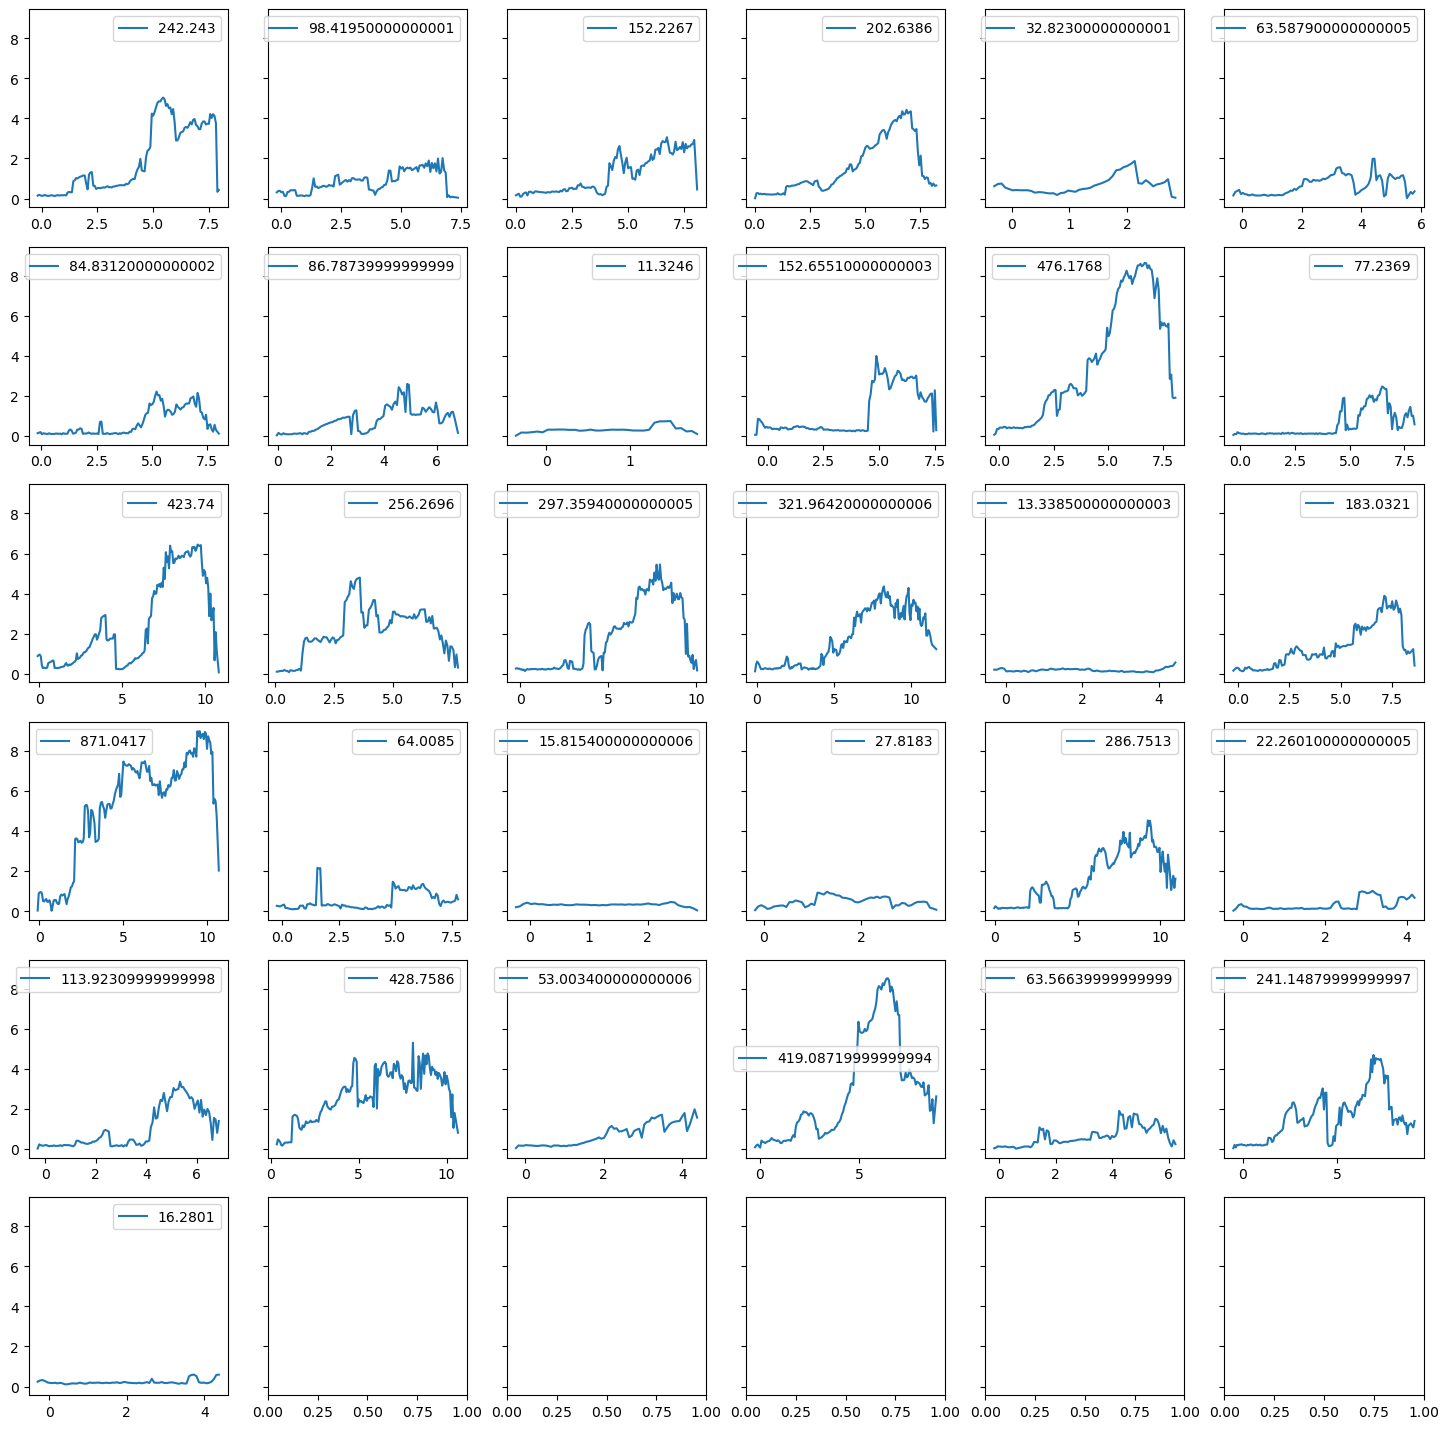

In [146]:
nb_slices = 1000
slices = np.linspace(merged[:,2].min(),merged[:,2].max(),nb_slices+1)

if len(list(set(merged[:,4]))[1:])<6:
    if len(list(set(merged[:,4]))[1:])/2 == int(len(list(set(merged[:,4]))[1:])/2):
        b = int(len(list(set(merged[:,4]))[1:])/2)
        a = int(len(list(set(merged[:,4]))[1:])/b)
else:
    b = 6
    a = int(len(list(set(merged[:,4]))[1:])/b)
        
if a*b < len(list(set(merged[:,4]))[1:]):
    a += 1
    
plt.subplots(a,b,figsize=(b*3,a*3),sharey=True)
i=0

dq = []
height = []

for region in list(set(merged[:,4]))[1:]:
    i+=1
    plt.subplot(a,b,i)
    points = merged[merged[:,4]==region]
    Slices = []
    MAX = []

    for Slice in range(nb_slices):
        slice_points = points[points[:,2]>=slices[Slice]] 
        slice_points = slice_points[slice_points[:,2]<slices[Slice+1]]
        if len(slice_points)>1:
            dX = slice_points[:,0].max()-slice_points[:,0].min()
            dY = slice_points[:,1].max()-slice_points[:,1].min()
            MAX.append(max(dX,dY))
            Slices.append(slices[Slice])
    Slices , MAX = np.array(Slices) , np.array(MAX)
    diff_quant = abs(MAX).sum()
    dq.append(diff_quant)
    height.append(points[:,2].max()-points[:,2].min())
    plt.plot(Slices,MAX,label=f'{diff_quant}')
    plt.legend()
plt.show()


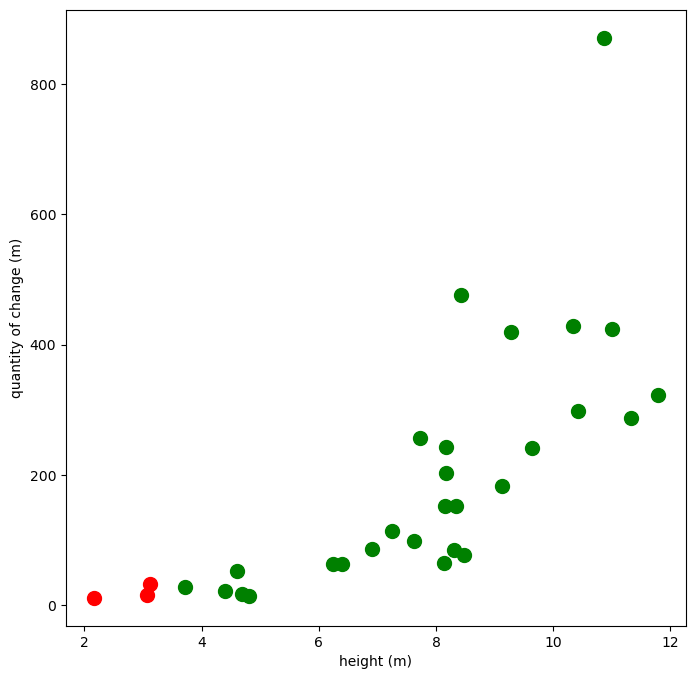

90.3225806451613 % of the regions are satisfying


In [147]:
min_h = 3.5

dq_sorted = np.sort(dq)[-nb_real_trees:]

plt.figure(figsize=(8,8))

i=0
C = []
for region in list(set(merged[:,4]))[1:]:
    points = merged[merged[:,4]==region]
    i+=1
    h = height[i-1]
    DQ = dq[i-1]
    if h<min_h:
        c= 'r'
    else:
        c = 'g'
    plt.scatter(h,DQ,marker='o',s=100,c=c)
    C.append(c)

C=np.array(C)   
plt.xlabel('height (m)')
plt.ylabel('quantity of change (m)')
plt.show()

print(100*len(C[C=='g'])/len(C),'% of the regions are satisfying')

/var/folders/8x/pskxz7p90fj8tlplywvgq0sw0000gn/T/ipykernel_7470/596726102.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(a,b,i,projection='3d')


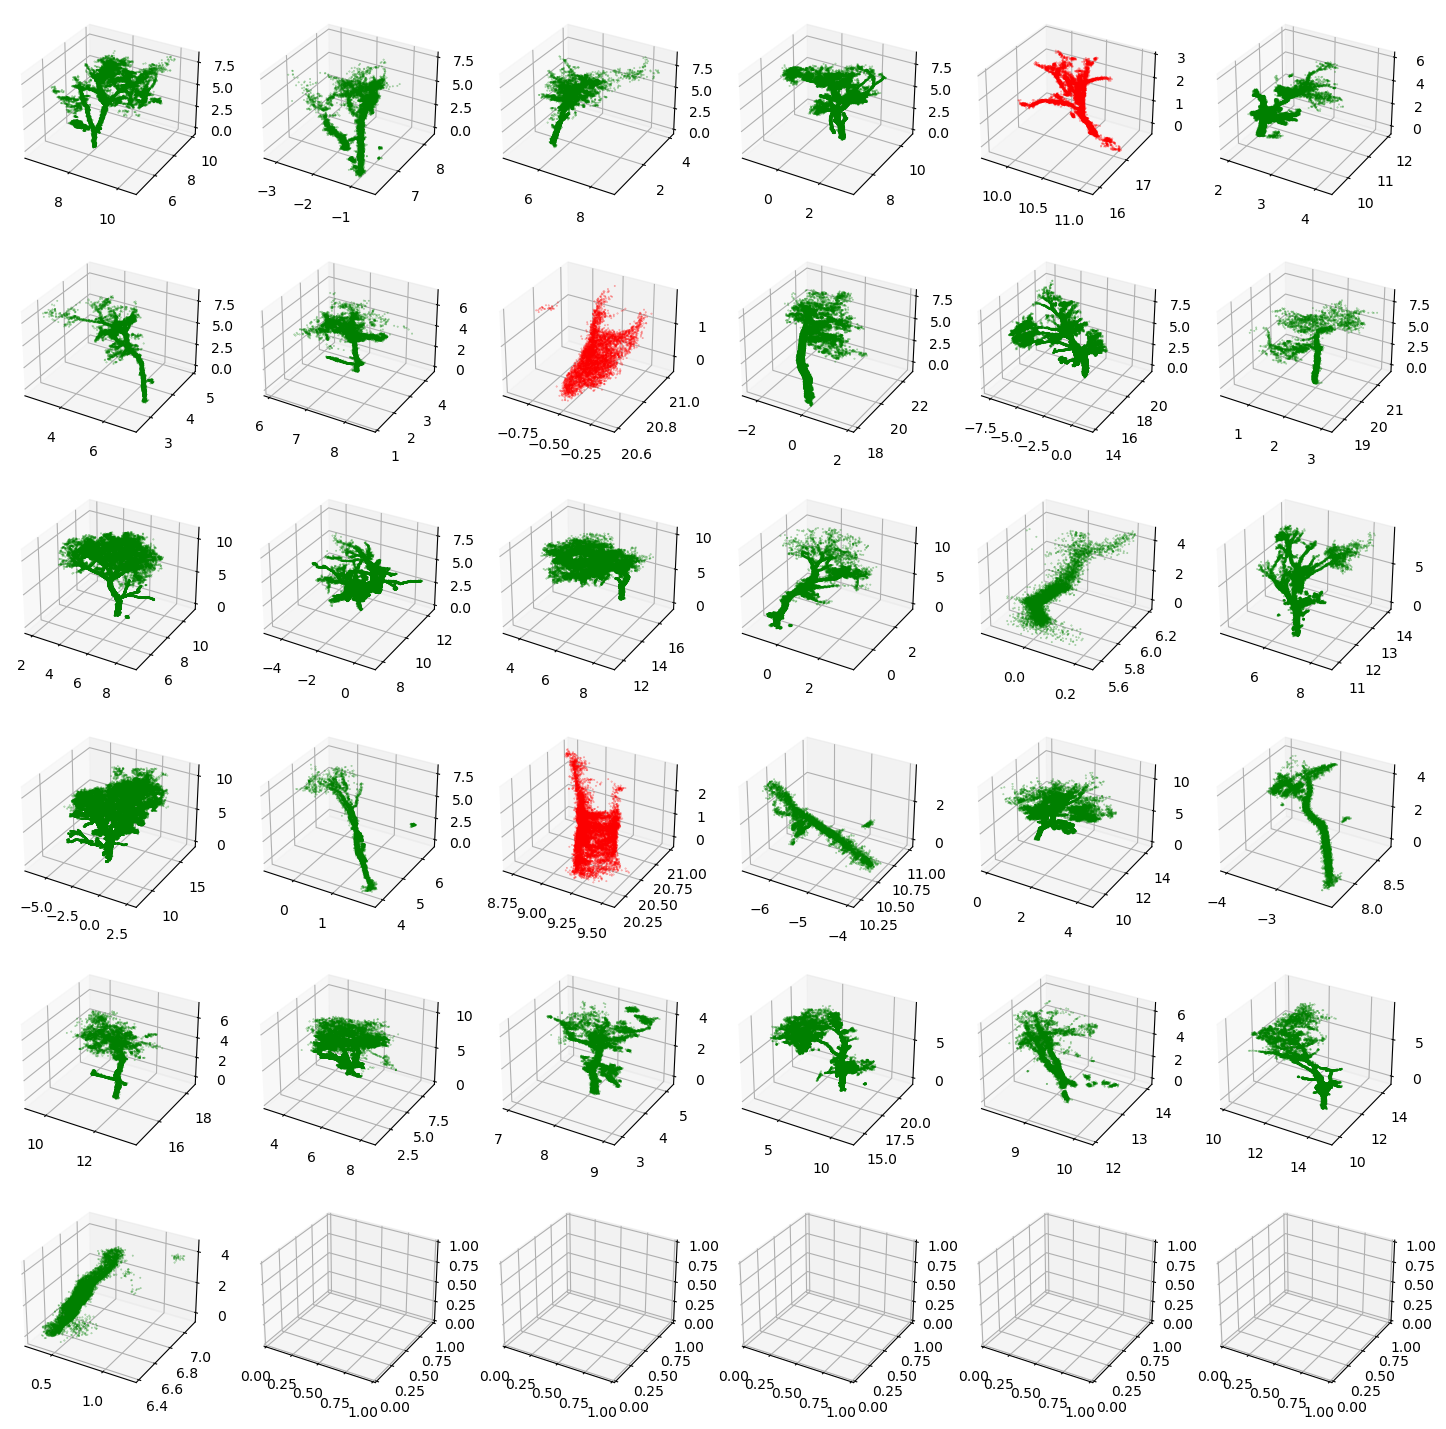

In [148]:
if len(list(set(merged[:,4]))[1:])<6:
    if len(list(set(merged[:,4]))[1:])/2 == int(len(list(set(merged[:,4]))[1:])/2):
        b = int(len(list(set(merged[:,4]))[1:])/2)
        a = int(len(list(set(merged[:,4]))[1:])/b)
else:
    b = 6
    a = int(len(list(set(merged[:,4]))[1:])/b)
        
if a*b < len(list(set(merged[:,4]))[1:]):
    a += 1
    
plt.subplots(a,b,subplot_kw={"projection": "3d"},figsize=(b*3,a*3))
i=0
for region in list(set(merged[:,4]))[1:]:
    i+=1
    ax = plt.subplot(a,b,i,projection='3d')
    points = merged[merged[:,4]==region]
    ax.scatter(points[:,0],points[:,1],points[:,2],s=0.1,c=C[i-1],alpha=0.5)
plt.show()

In [149]:
path_tree = '4-separated_trees/Trees/'
path_not_satisfying = '4-separated_trees/not_satisfying/'

for root, dirs, files in os.walk(path_tree):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        shutil.rmtree(os.path.join(root, d))

for root, dirs, files in os.walk(path_not_satisfying):
    for f in files:
        os.unlink(os.path.join(root, f))
    for d in dirs:
        shutil.rmtree(os.path.join(root, d))

i=0
for region in list(set(merged[:,4]))[1:]:
    
    points = merged[merged[:,4]==region]
    
    i = i+1
    output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
    output_file.X = (points[:,0]/scale[0]).astype(int)
    output_file.Y = (points[:,1]/scale[1]).astype(int)
    output_file.Z = (points[:,2]/scale[2]).astype(int)
    output_file.x = points[:,0]
    output_file.y = points[:,1]
    output_file.z = points[:,2]
    output_file.intensity = points[:,3]
    if C[i-1]=='r':
        path = '4-separated_trees/not_satisfying/'
    else:
        path = path_tree
    if i<10:
        output_file.write(f"{path}tree0{i}.las")
    else:
        output_file.write(f"{path}tree{i}.las")